In [1]:
# Install python packages to run this notebook - CLICK ON RESTART RUNTIME
!pip install rasterio geopandas osmnx unidecode pyrsgis

     |████████████████████████████████| 19.3MB 1.2MB/s 
     |████████████████████████████████| 1.0MB 47.4MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 245kB 50.6MB/s 
     |████████████████████████████████| 15.4MB 132kB/s 
     |████████████████████████████████| 6.6MB 49.8MB/s 
     |████████████████████████████████| 1.0MB 42.9MB/s 
     |████████████████████████████████| 10.3MB 46.9MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing instal

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


# Project "How green is my city ?" - Inference

In this notebook, we perform the inference for the project "How Green is my city" (step 2):
- given city coordinates
- we take a satellite image of this city from google earth engine
- we load the model of neural network that we have previously trained
- we feed this neural network with the new satellite image to perform the binary prediction green / built-up areas.
- we get the city limits with OSM and we compute fine ratio = green area/ city area
   

## Import modules

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import osmnx as ox
import pandas as pd

import rasterio
from rasterio import features
from rasterio.plot import show
import rasterio.mask

import os
from os import path as op
from shapely.wkt import loads

import unidecode

%matplotlib inline

In [4]:
from tensorflow import keras
from pyrsgis import raster
from pyrsgis.convert import changeDimension

Warning! matplotlib_scalebar library not found. You may not be able to export map directly.


In [35]:
from ModuleInstaller import installModule
from sat_tools import crop_area

No conda


# Ask for city coordinates and get satellite image

Note: in final version, the name of the city of interest should be asked to user and should be a parameter. Here it is fixed.

In [5]:
area = "Roquefort"

## Receive any coordinate set or place name and get a coordinate set for data download

Get area_name, and place_area (geodataframe used to get city limits)

In [6]:
# Any place worlwide you want (city/place name, country)
# place_name = input('Any worlwide place to search (as "Paris, France"): ')
place_name = 'Roquefort les pins, France'

# search the place area, based on the given name  
place_area = ox.geocoder.geocode_to_gdf(place_name)
print('Got the following place: ' + place_area.display_name[0])
area_name = place_area.display_name[0].replace(' ','_').replace(',','').replace("'","")
area_name = unidecode.unidecode(area_name)[:80]
print(area_name)


Got the following place: Roquefort-les-Pins, Grasse, Maritime Alps, Provence-Alpes-Côte d'Azur, Metropolitan France, 06330, France
Roquefort-les-Pins_Grasse_Maritime_Alps_Provence-Alpes-Cote_dAzur_Metropolitan_F


## Retrieve images from earth engine of Sentinel 2 Satellites

At the moment, we take a satellite image that has been already downloaded from Google Earth Engine and croped (done in Jupyter notebook Create sat images and OSD shapes V3.ipynb)

In [7]:
featuresFile_pred = '/content/drive/MyDrive/how-green-is/sat_images/places/sentinel2_Roquefort-les-Pins_Grasse_Maritime_Alps_Provence-Alpes-Cote_dAzur_Metr/sentinel2_image_cropped.tif'

In [30]:
labelsFile_pred = '/content/drive/MyDrive/how-green-is/sat_images/places/sentinel2_Roquefort-les-Pins_Grasse_Maritime_Alps_Provence-Alpes-Cote_dAzur_Metr/labels.tif'

In [8]:
# Read the rasters as array
ds, featuresPredArea = raster.read(featuresFile_pred, bands='all')

# We get 3D numpy array, with dimensions [band, row, col]
print(featuresPredArea.shape)  

(10, 631, 852)


In [9]:
with rasterio.open(featuresFile_pred, 'r') as src:
  print(src.meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 852, 'height': 631, 'count': 10, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, 7.018447483297409,
       0.0, -8.983152841195215e-05, 43.70070295267601)}


# Load model and perform prediction

In [10]:
from keras.models import load_model

# load step1 pre-trained model
model = load_model('model_step2.h5')

In [11]:
# Reshape the array to single dimensional array
featuresPredArea = changeDimension(featuresPredArea)

# Final image should be normalised as well
featuresPredArea = featuresPredArea / 65535.0

# Reshape the data
featuresPredArea = featuresPredArea.reshape((featuresPredArea.shape[0], 1, featuresPredArea.shape[1]))

# Print the shape of reshaped data
print(featuresPredArea.shape)

(537612, 1, 10)


In [12]:
# Predict new data
predicted = model.predict(featuresPredArea)
predicted = predicted[:,1]

In [13]:
# Reshape and export the probability raster
prediction = np.reshape(predicted, (ds.RasterYSize, ds.RasterXSize))
outFile_pred = area + '_predicted.tif'
raster.export(prediction, ds, filename=outFile_pred, dtype='float')

# Green ratio computation

Ratio computation with city limits

In [15]:
# Apply city mask for more precise computation
pred_croped_filename = area + '_pred_croped.tif'
with rasterio.open(outFile_pred) as pred_src:
  # Mask and the area should be in the same coordinate sytem 
  print(pred_src.crs)
  place_area.to_crs(crs=pred_src.crs, inplace=True)
  crop_area(pred_src, place_area, pred_croped_filename)


EPSG:4326


In [16]:
# Make the computation on new croped prediction

pred_src = rasterio.open(pred_croped_filename)
prediction = pred_src.read(1) 
# convert to single dim array
predicted = np.reshape(prediction, (prediction.shape[0]*prediction.shape[1],)) 

# Loop on the array to perform green area computation
sum = 0
sum_bin = 0
count = 0
for pixel_val in predicted:
  if pixel_val>=0: # take positive values only as negative values mean no data
    count = count + 1
    # sum of probability values
    sum = sum + pixel_val
    if pixel_val>0.5: # case green pixel
      # Binary count 
      sum_bin = sum_bin + 1

green_ratio = sum/count
print("Green ratio on the area with city limits, taking pixel soft probabilities:",green_ratio)
green_ratio_bin = sum_bin/count
print("Green ratio on the area with city limits, with binary classification:",green_ratio_bin)

Green ratio on the area with city limits, taking pixel soft probabilities: 0.38782074358126567
Green ratio on the area with city limits, with binary classification: 0.3906203432398493


# Visualisation of predicted image

A GeoTIFF is a standard .tif or image file format that includes additional spatial (georeferencing) information embedded in the .tif file as tags

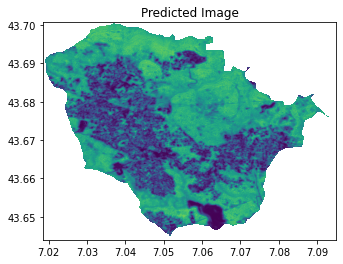

Image Coordinate Reference System: EPSG:4326


In [31]:
filename = pred_croped_filename
with rasterio.open(filename) as img:
  plt.title("Predicted Image")
  show(img)
  print("Image Coordinate Reference System:",img.crs )

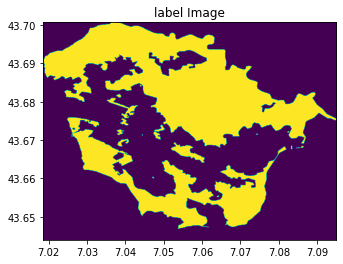

Image Coordinate Reference System: EPSG:4326


In [32]:
with rasterio.open(labelsFile_pred) as img:
  plt.title("label Image")
  show(img)
  print("Image Coordinate Reference System:",img.crs )

## Visualisation on a map with folium
It would be nice to plot the mask on a map. We will use folium for that:

https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/ImageOverlay.ipynb


In [19]:
!pip install folium

In [20]:
import folium

folium.raster_layers.ImageOverlay() expects the raster array to correspond to World Geodetic System (WGS84) if we ask the function to perform the Mercator projection (mercator_project=True).
In addition, we need to know the bounds of the image, not the bounds of the data raster, expressed in latitude and longitude.
Therefore we perform a projection of our data in World Geodetic System (WGS84 -> EPSG:4326)

### World Geodetic System projection (WGS84)

Rasterio has a function to reproject.

https://rasterio.readthedocs.io/en/latest/topics/reproject.html?highlight=warp


In [23]:
pred_file_wsg84 = area + '_predicted_EPSG4326.tif'
dst_crs = 'EPSG:4326' # World Geodetic System (WGS84) 
change_image_projection(filename, pred_file_wsg84, dst_crs)

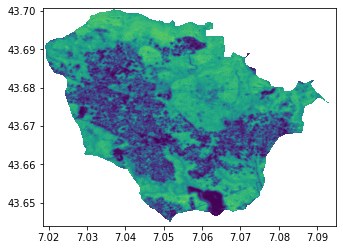

image bounds: BoundingBox(left=7.018447483297409, bottom=43.64401925824807, right=7.09498394550439, top=43.70070295267601)
CRS: EPSG:4326


In [24]:
with  rasterio.open(pred_file_wsg84) as img:
  prediction_wsg84 = img.read(1)
  show(img)
  print("image bounds:", img.bounds)
  image_box = img.bounds
  print("CRS:",img.crs)

In [25]:
N_lat = image_box.top
S_lat = image_box.bottom
W_long = image_box.left
E_long = image_box.right

In [29]:
# Center the map at the center of the area of interest, thanks to latitude and longitude coordinates:
m = folium.Map([(N_lat+S_lat)/2,(W_long+E_long)/2], zoom_start=11)

# Plot the mask on the map with folium ImageOverlay function 
folium.raster_layers.ImageOverlay(
    image=prediction_wsg84,
    bounds=[[S_lat, W_long], [N_lat, E_long]],
    opacity=0.5,
    interactive=True,
    cross_origin=False,
    colormap=lambda x: (0, 1, 0, x), # plot green areas in green
    mercator_project=True # Ask folium to do the mercator projection
).add_to(m)

place_area.to_crs(crs='EPSG:4326', inplace=True)
folium.GeoJson(place_area, style_function=lambda x: {'fillColor': '#00000000'}, name='Area contour').add_to(m)

m